# YIN pitch tracking algorithm
In this Jupiter notebook I implement the YIN algorithm. A more detailed description of it can be found in [this paper](http://audition.ens.fr/adc/pdf/2002_JASA_YIN.pdf). 

In [66]:
from scipy import signal as sg
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

To test the algorithm I use [this sound](https://freesound.org/people/daalvinz/sounds/367215/) from [freesound](https://freesound.org/).

In [92]:
# Load the file and convert to mono. Divided by 2**15 - 1 to normalize the data between -1 and 1.
# I take the first two seconds of the audio because there were some zero values at the end.
fs, audio = wavfile.read('427200__thescarlettwitch89__female-ooh-singing-voice-cleaned-with-reverb-by-erokia.wav')
audio = audio[:,0]

C:\Users\alber\AppData\Local\Temp\ipykernel_2492\2429612545.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio = wavfile.read('427200__thescarlettwitch89__female-ooh-singing-voice-cleaned-with-reverb-by-erokia.wav')


Text(0.5, 1.0, 'Input audio in the time domain')

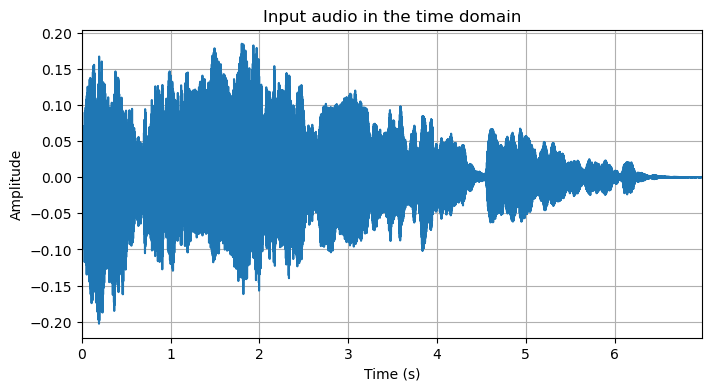

In [94]:
# Plot the audio file
plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(audio))/fs, audio)
plt.xlim(0, len(audio)/fs)
plt.grid(True)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Input audio in the time domain')

(0.0, 6.8979791666666666)

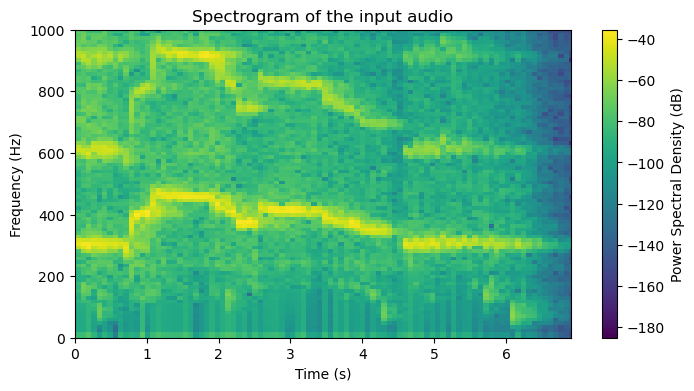

In [106]:
plt.rcParams.update({"axes.grid" : False})
W = 2**12
window = sg.get_window('hamming', W)
frequencies, times, spectrogram = sg.spectrogram(audio, fs, window)
plt.figure(figsize=(8, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram of the input audio')
plt.colorbar(label='Power Spectral Density (dB)')
plt.ylim(0, 1000)
plt.xlim([0, (len(audio) - W)/fs])

In [96]:
# This function takes in an array and finds the first local minima below a given threshold.
def find_first_local_min_below_threshold(array, threshold):
  local_minima_indices = sg.argrelmin(array)[0]
  for idx in local_minima_indices:
      if array[idx] < threshold:
          return idx
  return None

In [17]:
# This function performs the parabolic interpolation to find the exact x position of the local minima.
def parabolic_interp(prev, max, next):
    numerator = prev - next
    denominator = prev - 2 * max + next
    
    x_max = 0.5 * numerator / denominator
    
    return x_max

This is what the input signal looks like at a closer inspection.

Text(0.5, 1.0, 'Segment of the audio file')

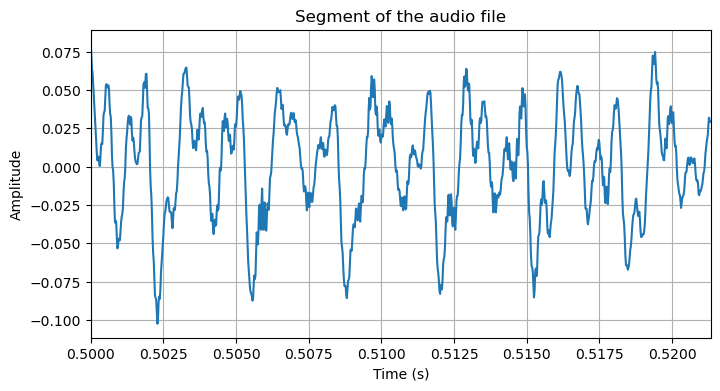

In [97]:
plt.figure(figsize=(8, 4))

# Plot of 1024 samples of the audio file
plt.plot(np.arange(fs//2, fs//2 + 1024)/fs, audio[fs//2 : fs//2 + 1024])
plt.xlim([fs//2/fs, (fs//2 + 1024)/fs])
plt.grid(True)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Segment of the audio file')

In [33]:
# Function that calculates the difference between the squared signal and its delayed version.
def difference(x, W, max_tau):
  diff = [0] * (max_tau + 1)
  for tau in range(max_tau + 1):
    for j in range(1, W - tau):
      diff[tau] += (x[j] - x[j + tau])**2
  return diff

(0.0, 500.0)

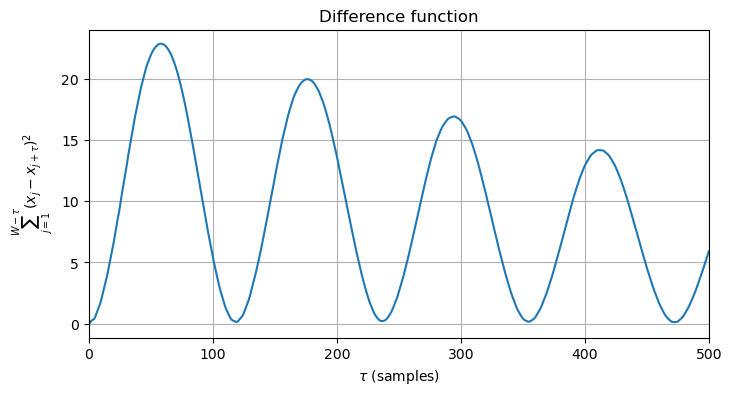

In [98]:
plt.figure(figsize=(8, 4))
x = audio[fs : fs + 1024]
plt.plot(difference(x, 1024, 500))
plt.xlabel(r'$\tau$ (samples)')
plt.ylabel(r'$\sum_{j=1}^{W-\tau} (x_j - x_{j+\tau})^2$')
plt.title('Difference function')
plt.grid(True)
plt.xlim(0, 500)

In [34]:
# Function that calculates the cumulative mean normalized difference function.
def computeCmndf(x, W, min_tau, max_tau):
  cmndf = np.empty(max_tau - min_tau)
  diff = difference(x, W, max_tau)
  for tau in range(min_tau, max_tau):
    if tau == 0:
      cmndf[tau - min_tau] = 1
    else:
      sum = np.sum(diff[1:tau+1])
      cmndf[tau - min_tau] = diff[tau] / (sum / tau)
  return cmndf

(0.0, 960.0)

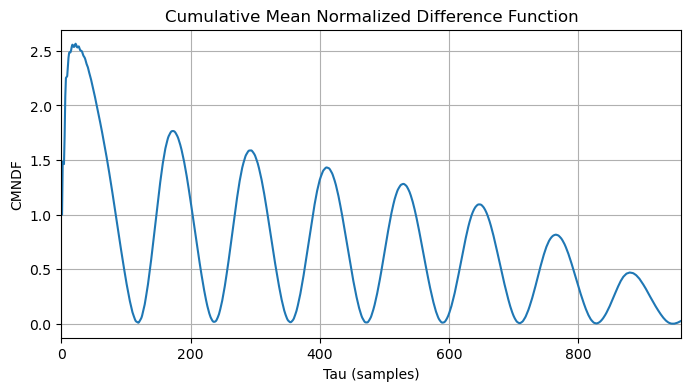

In [99]:
min_tau = 0
max_tau = fs//50
W = 1024
cmndf_threshold = 0.15

cmndf = computeCmndf(x, W, min_tau, max_tau)

plt.figure(figsize=(8, 4))
plt.plot(cmndf)
plt.xlabel('Tau (samples)')
plt.ylabel('CMNDF')
plt.title('Cumulative Mean Normalized Difference Function')
plt.grid(True)
plt.xlim([0, max_tau - min_tau])

In [100]:

def pitchDetect(audio, fs, W, min_f0, max_f0, cmndf_threshold):
  res = []
  min_tau = fs // max_f0
  max_tau = fs // min_f0

  for start in range(0, len(audio), W//2):
    x = audio[start:start+W]
    if (len(x) != W):
      break
    cmndf = computeCmndf(x, W, min_tau, max_tau)
    predicted_tau = find_first_local_min_below_threshold(cmndf, cmndf_threshold)
    if predicted_tau != None:
      interp_add = parabolic_interp(cmndf[predicted_tau - 1], cmndf[predicted_tau], cmndf[predicted_tau + 1])
      delay = min_tau + predicted_tau + interp_add
      f0 = fs / delay
      res.append(f0)
    else:
      res.append(None)
  return np.array(res)

In [102]:
min_f0 = 75
max_f0 = 800
W = 1024
cmndf_threshold = 0.2

f0 = pitchDetect(audio, fs, W, min_f0, max_f0, cmndf_threshold)

Text(0.5, 1.0, 'Pitch Estimation over the spectrogram')

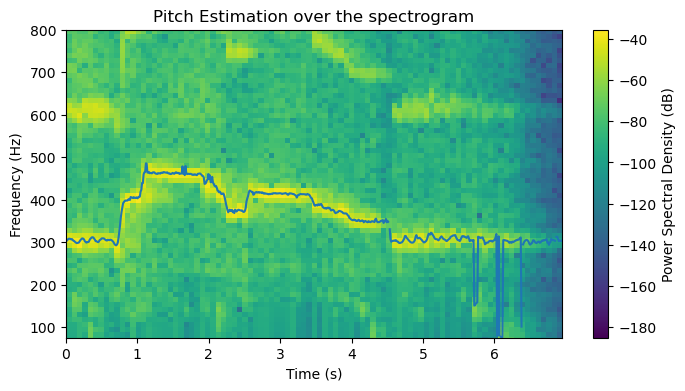

In [114]:
plt.rcParams.update({"axes.grid" : False})
frequencies, times, spectrogram = sg.spectrogram(audio, fs, window = window)
plt.figure(figsize=(8, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power Spectral Density (dB)')
plt.plot(np.arange(0, len(f0) * (W//2), (W//2))/fs, f0)
plt.ylim(min_f0, max_f0)
plt.xlim(0, (len(f0) - 2) * (W//2) / fs)

plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Pitch Estimation over the spectrogram')